<a href="https://colab.research.google.com/github/arizonaCameraLab/computationalImaging/blob/master/Chapter8FocalImaging/FourierAnalysisOfIncoherentImaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fourier Analysis of Incoherent Imaging
## David Brady
## University of Arizona
## August 2022

## libraries

In [6]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 22})
#from google.colab import files
from scipy.special import jn, jn_zeros


## Transfer Functions

The 3D bandpass function is
  \begin{equation}
    B(\Delta x, \Delta y, q)=
   {2\over \Delta x^2+\Delta y^2} \Re \left [\sqrt{(\Delta
   x^2+\Delta y^2)A^2-(\Delta x^2+\Delta y^2+2
   |q|)^2}\right ]
  \end{equation}

  The transfer function for 2D imaging is

  \begin{equation}
  {\cal H}(\mu )={2\over \pi}\Re \left ( {\rm arccos}\left (\mu  \lambda f /\# \right )-\left (\mu  \lambda f/\# \right )\sqrt{1-\left (\mu  \lambda f/\# \right )^2}\right )
\end{equation}

In [7]:
def jinc(x):
  # impulse response
  ji=2*jn(1,np.pi*(x+10**(-8)))/(np.pi*(x+10**(-8)))
  return ji
def pupil(x):
  p=1-np.heaviside(np.abs(x)-.5,0)
  return p
def B(u,v,q):
  # bandpass for u,v in units of A, q in units of A^2
  b=(2/(u**2+v**2))*np.real(np.emath.sqrt((u**2+v**2)-(u**2+v**2+2*np.abs(q))**2))
  return b
def H(u):
  # incoherent imaging transfer function for u in units of 1/(lambda f/#)
  h=(2/np.pi)*np.real(np.emath.arccos(u)-u*np.emath.sqrt(1-u**2))
  return h

## band volume

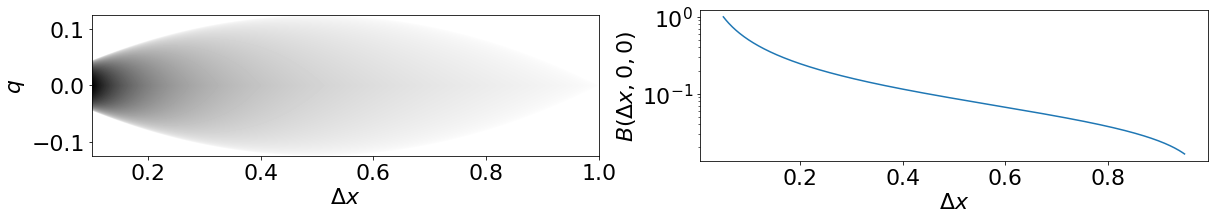

In [9]:
plt.rcParams['figure.figsize'] = [20, 7]
fig, (ax1, ax2) = plt.subplots(1,2)
x=np.linspace(.1,1,512)
dx, q = np.meshgrid(x,np.linspace(-.125,.125,512))
b= B(dx,0,q)
ax1.imshow(b, extent=[.1,1,-.125,.125], cmap='binary')
ax1.set_xlabel(r'$\Delta x$')
ax1.set_ylabel(r'$q$')
x=np.linspace(.05,.95,512)
ax2.semilogy(x, B(x,0,0)/B(.05,0,0))
ax2.set_xlabel(r'$\Delta x$')
ax2.set_ylabel(r'$B(\Delta x,0,0)$')
axes=plt.gca()
axes.set_aspect(.15)
plt.savefig('bandVolume.pdf')
#files.download('bandVolume.pdf')

## optical transfer function for a circular aperture

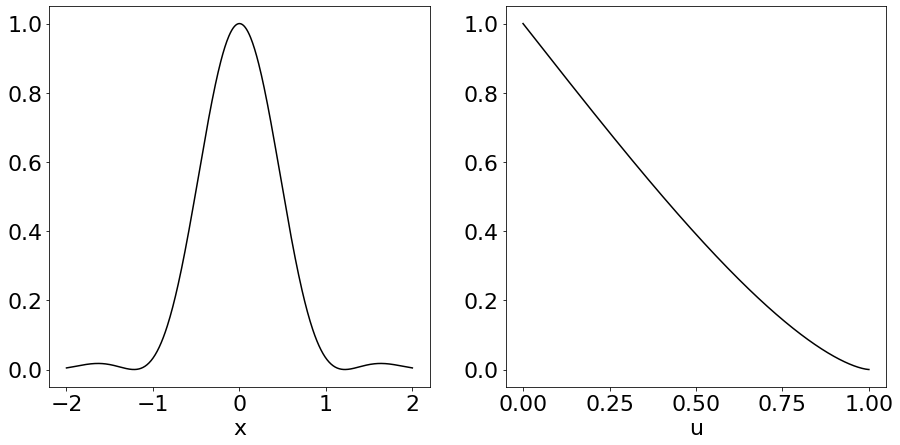

In [11]:
plt.rcParams['figure.figsize'] = [15, 7]
fig, (ax1,ax2)= plt.subplots(1,2)
x=np.linspace(-2, 2, 512)
ax1.plot(x,jinc(x)**2, 'k')
ax1.set_xlabel('x')
u = np.linspace(0, 1, 512)
ax2.plot(u,H(u), 'k')
ax2.set_xlabel('u')
plt.savefig('otf.pdf')
#files.download('otf.pdf')

## optical transfer function for an annulus

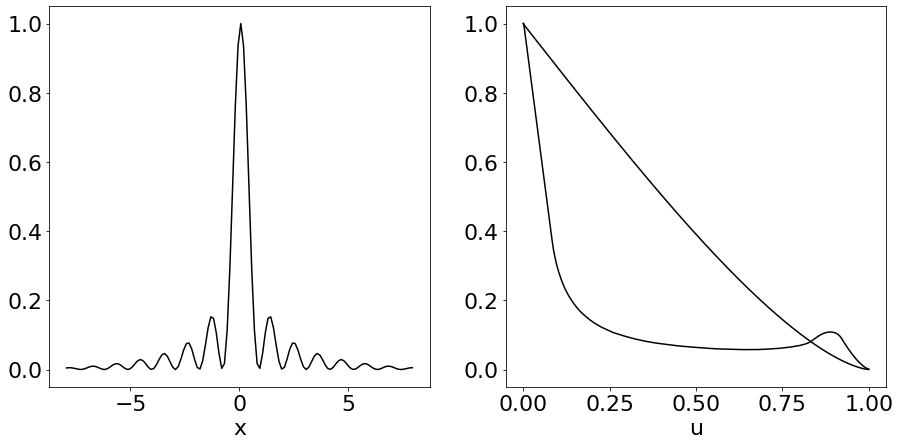

In [16]:
plt.rcParams['figure.figsize'] = [15, 7]
fig, (ax1,ax2)= plt.subplots(1,2)
u = np.linspace(-4, 4, 2048)
U, V= np.meshgrid(u,u)
X=1/(2*(u[1]-u[0]))
x=np.linspace(-X,X,2048)
p=pupil(np.sqrt(U**2+V**2))-pupil(1.2*np.sqrt(U**2+V**2))
impulse=np.abs(np.fft.fftshift(np.fft.fft2(p)))**2
impulse=impulse/np.max(impulse)
ax1.plot(x[960:1088],impulse[960:1088,1024], 'k')
ax1.set_xlabel('x')
OTF=np.abs(np.fft.fftshift(np.fft.ifft2(impulse)))
OTF=OTF/np.max(OTF)
ax2.plot(u[1024:1280],OTF[1024,1024:1280], 'k')
uO = np.linspace(0, 1, 512)
ax2.plot(uO,H(uO), 'k')
ax2.set_xlabel('u')
plt.savefig('otfAnnulus.pdf')
#files.download('otfAnnulus.pdf')

## image transformations

Here we consider the same image as was previously considered with coherent imaging. We assume that the object ranges from -64 $\lambda$ f/# to 64 $\lambda$ f/# and the sampling period is $\frac{\lambda f/\#}{4}$. For an incoherent system, the image must be real and positive. Writing the signal as
$$f(x)=1+\cos (2\pi \alpha x^2)$$
we set we set $\alpha= \frac{1}{128(\lambda f/\#)^2}$, which means that at the edge of the field, the spatial frequency is approximately $\frac{0.5}{\lambda f/\#}$

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

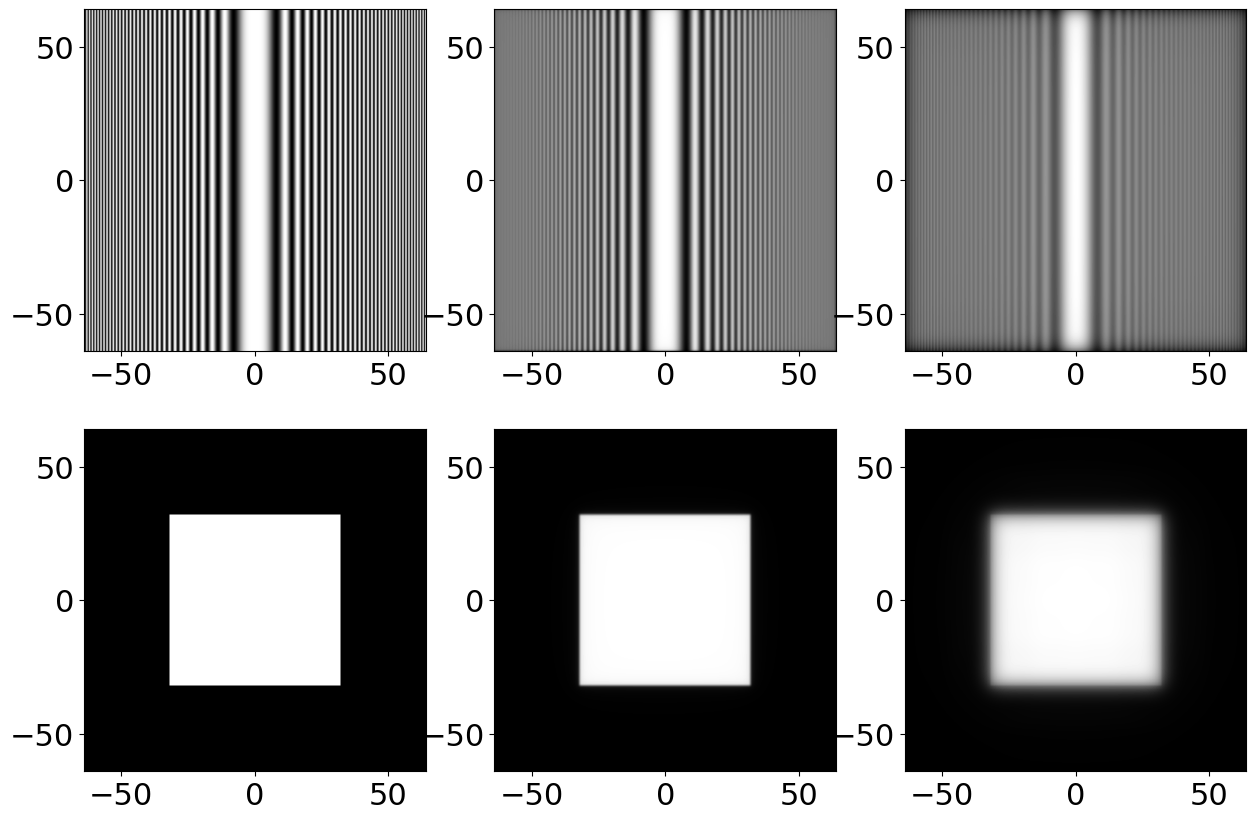

In [ ]:
plt.rcParams['figure.figsize'] = [15, 10]
X=64
N=1024
dx=2*X/(N-1)
B=1/(2*dx)
side = np.linspace(-X, X, N)
X, Y = np.meshgrid(side, side)
u = np.linspace(-B, B, 2*N)
U, V= np.meshgrid(u,u)
# true image Image value must be real and positive.
alpha=1./128.
Z = 1+np.cos(2*np.pi*alpha*X**2)
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2,3)
ax1.imshow(Z, cmap='gray', extent=[-64,64,-64,64], aspect='equal')
# low pass filtered by cicular pupil
zz=np.zeros((2*N,2*N))
zz[np.int16(N/2):np.int16(3*N/2),np.int16(N/2):np.int16(3*N/2)]=Z
zzft=np.fft.fftshift(np.fft.fft2(zz))
zzftFiltered=zzft*H(np.sqrt(U**2+V**2))
zzFiltered=np.real(np.fft.ifft2(np.fft.ifftshift(zzftFiltered)))[np.int16(N/2):np.int16(3*N/2),np.int16(N/2):np.int16(3*N/2)]
ax2.imshow(zzFiltered, cmap='gray', extent=[-64,64,-64,64], aspect='equal')
# High pass filtered by annular pupil
zz=np.zeros((2*N,2*N))
zz[np.int16(N/2):np.int16(3*N/2),np.int16(N/2):np.int16(3*N/2)]=Z
zzft=np.fft.fftshift(np.fft.fft2(zz))
zzftFiltered=zzft*OTF
zzFiltered=np.real(np.fft.ifft2(np.fft.ifftshift(zzftFiltered)))[np.int16(N/2):np.int16(3*N/2),np.int16(N/2):np.int16(3*N/2)]
ax3.imshow(zzFiltered, cmap='gray', extent=[-64,64,-64,64], aspect='equal')
# different object
# true image
Z=np.zeros((N,N))
Z[np.int16(N/4):np.int16(3*N/4),np.int16(N/4):np.int16(3*N/4)]=1
ax4.imshow(Z, cmap='gray', extent=[-64,64,-64,64], aspect='equal')
# low pass filtered by cicular pupil
zz=np.zeros((2*N,2*N))
zz[np.int16(N/2):np.int16(3*N/2),np.int16(N/2):np.int16(3*N/2)]=Z
zzft=np.fft.fftshift(np.fft.fft2(zz))
zzftFiltered=zzft*H(np.sqrt(U**2+V**2))
zzFiltered=np.real(np.fft.ifft2(np.fft.ifftshift(zzftFiltered)))[np.int16(N/2):np.int16(3*N/2),np.int16(N/2):np.int16(3*N/2)]
ax5.imshow(zzFiltered, cmap='gray', extent=[-64,64,-64,64], aspect='equal')
# High pass filtered by annular pupil
zz=np.zeros((2*N,2*N))
zz[np.int16(N/2):np.int16(3*N/2),np.int16(N/2):np.int16(3*N/2)]=Z
zzft=np.fft.fftshift(np.fft.fft2(zz))
zzftFiltered=zzft*OTF
zzFiltered=np.real(np.fft.ifft2(np.fft.ifftshift(zzftFiltered)))[np.int16(N/2):np.int16(3*N/2),np.int16(N/2):np.int16(3*N/2)]
ax6.imshow(zzFiltered, cmap='gray', extent=[-64,64,-64,64], aspect='equal')
plt.savefig('incoherentFiltering.pdf')
files.download('incoherentFiltering.pdf')